In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries loaded")

Libraries loaded


---
# COVID Holdout Test: Robustness Check
---

**Goal:** Test models trained in notebooks 06-07 on the COVID period (2020-2023)

**Methodology (matching notebooks 06-07):**
- **Baseline:** AR(2) = ARIMA(2, 0, 0) - **NO differencing**
- **ARIMAX:** ARIMAX(2, 0, 0) + **1-quarter LAGGED topics** - **NO differencing**
- **Training:** 1990Q1-2019Q4 (120 quarters, same as CV period)
- **Testing:** 2020Q1-2023Q4 (16 quarters, COVID holdout)

**Key Point:** I use the SAME model specification as notebooks 06-07:
- Models were trained/selected using 2010-2019 cross-validation
- COVID period (2020-2023) was EXCLUDED from model training
- Now I test if those models still work during the pandemic

**Output Files:**
- `results/covid_holdout_k6.csv`
- `results/covid_holdout_k25.csv`

---

### Step 1: Load Data and Define COVID Split

In [2]:
# Load merged datasets with topics
df_k6 = pd.read_csv('data/wui_topics_merged_k6.csv')
df_k6['quarter'] = pd.PeriodIndex(df_k6['quarter'], freq='Q')
df_k6 = df_k6.set_index('quarter')

df_k25 = pd.read_csv('data/wui_topics_merged_k25.csv')
df_k25['quarter'] = pd.PeriodIndex(df_k25['quarter'], freq='Q')
df_k25 = df_k25.set_index('quarter')

# Get topic columns
topic_cols_k6 = [col for col in df_k6.columns if col.startswith('topic_')]
topic_cols_k25 = [col for col in df_k25.columns if col.startswith('topic_')]

# Define COVID period split: Train on 1990-2019, Test on 2020-2023
train_end = pd.Period('2019Q4', freq='Q')
test_start = pd.Period('2020Q1', freq='Q')
test_end = pd.Period('2023Q4', freq='Q')

### Step 2: Define Forecasting Functions (Same as Notebook 07)

In [3]:
def forecast_ar2_covid(df, target_col):
    """
    AR(2) baseline (same as Notebook 07)
    NO differencing (d=0)
    """
    df_train = df[df.index <= train_end]
    df_test = df[(df.index >= test_start) & (df.index <= test_end)]
    
    y_train = df_train[target_col]
    y_test = df_test[target_col]
    
    try:
        model = ARIMA(y_train, order=(2, 0, 0),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
        fitted = model.fit(method='innovations_mle')
        forecast = fitted.forecast(steps=len(y_test))
        
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        
        return y_test.values, forecast, rmse, mae
    except Exception as e:
        return None, None, None, None

def forecast_arimax_200_lagged_covid(df, target_col, exog_cols):
    """
    ARIMAX(2,0,0) with 1-quarter LAGGED topics (same as Notebook 07)
    NO differencing (d=0)
    
    TRUE FORECASTING: Uses topics from quarter t-1 to predict WUI at quarter t
    This ensures no look-ahead bias
    """
    df_train = df[df.index <= train_end]
    df_test = df[(df.index >= test_start) & (df.index <= test_end)]
    
    y_train = df_train[target_col]
    y_test = df_test[target_col]
    X_train = df_train[exog_cols]
    X_test = df_test[exog_cols]
    
    try:
        # Combine X_train and X_test BEFORE lagging
        # This ensures X_test_lagged[0] = X_train[-1] (not NaN!)
        X_combined = pd.concat([X_train, X_test])
        X_combined_lagged = X_combined.shift(1)
        
        # Split back into train and test
        X_train_lagged = X_combined_lagged.iloc[:len(X_train)]
        X_test_lagged = X_combined_lagged.iloc[len(X_train):]
        
        # Remove first row (NaN) from training data and align y
        X_train_lagged = X_train_lagged.iloc[1:]
        y_train_aligned = y_train.iloc[1:]
        
        # Fit model with lagged topics
        model = ARIMA(y_train_aligned, exog=X_train_lagged, order=(2, 0, 0),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
        fitted = model.fit(method='innovations_mle')
        
        # Forecast using lagged test topics
        # X_test_lagged[0] now correctly contains X_train[-1]
        forecast = fitted.forecast(steps=len(y_test), exog=X_test_lagged)
        
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        
        return y_test.values, forecast, rmse, mae
    except Exception as e:
        return None, None, None, None

### Step 3: Get Baseline AR(2) Performance

In [4]:
print("=" * 80)
print("BASELINE AR(2) PERFORMANCE (COVID PERIOD)")
print("=" * 80)

# Get baseline for K=6 data
_, _, baseline_rmse_k6, baseline_mae_k6 = forecast_ar2_covid(df_k6, 'wui')
print(f"\nBaseline AR(2) [K=6 data]:")
print(f"  RMSE: {baseline_rmse_k6:.2f}")
print(f"  MAE:  {baseline_mae_k6:.2f}")

# Get baseline for K=25 data
_, _, baseline_rmse_k25, baseline_mae_k25 = forecast_ar2_covid(df_k25, 'wui')
print(f"\nBaseline AR(2) [K=25 data]:")
print(f"  RMSE: {baseline_rmse_k25:.2f}")
print(f"  MAE:  {baseline_mae_k25:.2f}")

print("\n" + "=" * 80)

BASELINE AR(2) PERFORMANCE (COVID PERIOD)

Baseline AR(2) [K=6 data]:
  RMSE: 9954.08
  MAE:  8152.13

Baseline AR(2) [K=25 data]:
  RMSE: 9954.08
  MAE:  8152.13



### Step 4: Load CV Performance

In [5]:
# Load CV results from notebook 07
cv_k6 = pd.read_csv('results/summary_k6_ALL_COMBINATIONS.csv')
cv_k25 = pd.read_csv('results/summary_k25_SYSTEMATIC.csv')

# Create lookup dictionaries
cv_k6_dict = dict(zip(cv_k6['Model'], cv_k6['Improve_%']))
cv_k25_dict = dict(zip(cv_k25['Model'], cv_k25['Improve_%']))

### Step 5: Test All K=6 Models

In [6]:
from itertools import combinations

print("=" * 80)
print("TESTING K=6 MODELS ON COVID PERIOD")
print("=" * 80)

results_k6 = []

# Generate all combinations
all_combos_k6 = []
for r in range(1, len(topic_cols_k6) + 1):
    all_combos_k6.extend(combinations(topic_cols_k6, r))

print(f"\nTesting {len(all_combos_k6)} K=6 combinations...")

for i, topic_combo in enumerate(all_combos_k6, 1):
    if i % 10 == 0:
        print(f"  Progress: {i}/{len(all_combos_k6)}", end='\r')
    
    topics_list = list(topic_combo)
    model_name = 'K6_' + '_'.join([t.replace('topic_', 'T') for t in topics_list])
    
    # Use ARIMAX(2,0,0) with 1Q lagged topics
    _, _, rmse_covid, mae_covid = forecast_arimax_200_lagged_covid(df_k6, 'wui', topics_list)
    
    if rmse_covid is None:
        continue
    
    improve_covid = (baseline_rmse_k6 - rmse_covid) / baseline_rmse_k6 * 100
    cv_improve = cv_k6_dict.get(model_name, np.nan)
    
    results_k6.append({
        'Model': model_name,
        'RMSE_COVID': rmse_covid,
        'MAE_COVID': mae_covid,
        'Improve_COVID_%': improve_covid,
        'CV_Improve_%': cv_improve
    })

covid_k6 = pd.DataFrame(results_k6)
covid_k6 = covid_k6.sort_values('Improve_COVID_%', ascending=False)

print(f"\n\nCompleted: {len(covid_k6)} models tested")
print(f"Best: {covid_k6.iloc[0]['Improve_COVID_%']:.2f}%")
print("=" * 80)

TESTING K=6 MODELS ON COVID PERIOD

Testing 63 K=6 combinations...
  Progress: 60/63

Completed: 63 models tested
Best: 3.56%


### Step 6: Test K=25 Models

In [7]:
# ============================================================================
# STATISTICAL SIGNIFICANCE TEST FUNCTIONS
# ============================================================================

from scipy.stats import wilcoxon, norm, binomtest

def diebold_mariano_test(y_actual, forecast_baseline, forecast_model):
    """One-sided Diebold-Mariano test"""
    residuals_baseline = y_actual - forecast_baseline
    residuals_model = y_actual - forecast_model
    
    d = residuals_baseline**2 - residuals_model**2
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    
    if var_d == 0 or len(d) < 2:
        return 0.0, 1.0
    
    dm_stat = mean_d / np.sqrt(var_d / len(d))
    p_value = 1 - norm.cdf(dm_stat)
    
    return dm_stat, p_value

def sign_test(y_actual, forecast_baseline, forecast_model):
    """
    Sign test: Are absolute errors lower in majority of quarters?
    
    H0: Model wins 50% of quarters (random)
    H1: Model wins > 50% of quarters
    """
    abs_err_baseline = np.abs(y_actual - forecast_baseline)
    abs_err_model = np.abs(y_actual - forecast_model)
    
    wins = sum(abs_err_model < abs_err_baseline)
    n_quarters = len(y_actual)
    
    # One-sided binomial test
    result = binomtest(wins, n_quarters, 0.5, alternative='greater')
    
    return wins, n_quarters, result.pvalue

def wilcoxon_test(y_actual, forecast_baseline, forecast_model):
    """Wilcoxon signed-rank test on absolute errors"""
    abs_err_baseline = np.abs(y_actual - forecast_baseline)
    abs_err_model = np.abs(y_actual - forecast_model)
    
    try:
        stat, p_value = wilcoxon(abs_err_baseline, abs_err_model, 
                                 alternative='greater', zero_method='wilcox')
        return stat, p_value
    except:
        return np.nan, np.nan

def bootstrap_dm_test(y_actual, forecast_baseline, forecast_model, n_bootstrap=1000, seed=42):
    """Bootstrap Diebold-Mariano test"""
    np.random.seed(seed)
    
    residuals_baseline = y_actual - forecast_baseline
    residuals_model = y_actual - forecast_model
    
    d_obs = residuals_baseline**2 - residuals_model**2
    mean_obs = d_obs.mean()
    
    # Bootstrap under null
    d_centered = d_obs - mean_obs
    boot_means = []
    
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(d_centered), size=len(d_centered), replace=True)
        boot_means.append(d_centered[idx].mean())
    
    boot_means = np.array(boot_means)
    p_value = (boot_means >= mean_obs).mean()
    
    return mean_obs, p_value

def clark_west_test(y_actual, forecast_baseline, forecast_model):
    """Clark-West test for nested models"""
    residuals_baseline = y_actual - forecast_baseline
    residuals_model = y_actual - forecast_model
    
    n = len(residuals_baseline)
    mse_baseline = residuals_baseline**2
    mse_model = residuals_model**2
    
    # Adjustment for nested models
    adjustment = (forecast_baseline - forecast_model)**2
    
    f_bar = (mse_baseline - mse_model + adjustment).mean()
    var_f = (mse_baseline - mse_model + adjustment).var(ddof=1)
    
    if var_f == 0 or n < 2:
        return 0.0, 1.0
    
    cw_stat = f_bar / np.sqrt(var_f / n)
    p_value = 1 - norm.cdf(cw_stat)
    
    return cw_stat, p_value

### Step 7: Save Results

In [8]:
covid_k6.to_csv('results/covid_holdout_k6.csv', index=False)
covid_k25.to_csv('results/covid_holdout_k25.csv', index=False)

NameError: name 'covid_k25' is not defined

### Step 8: Display Summary

In [ ]:
print("=" * 80)
print("COVID HOLDOUT RESULTS (2020-2023)")
print("=" * 80)

print("\nK=6 Models (Top 5):")
print(covid_k6.head().to_string(index=False))

print("\nK=25 Models (Top 5):")
print(covid_k25.head().to_string(index=False))

best_k6 = covid_k6.iloc[0]
best_k25 = covid_k25.iloc[0]

print("\n" + "=" * 80)
print("BEST MODELS")
print("=" * 80)
print(f"\nK=6:  {best_k6['Model']}")
print(f"  RMSE: {best_k6['RMSE_COVID']:.1f}")
print(f"  Improvement: {best_k6['Improve_COVID_%']:.2f}%")

print(f"\nK=25: {best_k25['Model']}")
print(f"  RMSE: {best_k25['RMSE_COVID']:.1f}")
print(f"  Improvement: {best_k25['Improve_COVID_%']:.2f}%")
print("=" * 80)

COVID HOLDOUT RESULTS (2020-2023)

K=6 Models (Top 5):
         Model  RMSE_COVID   MAE_COVID  Improve_COVID_%  CV_Improve_%
K6_T2_T3_T4_T5 9599.333358 7929.056511         3.563802      8.800112
   K6_T2_T3_T4 9784.910814 8072.192799         1.699466      7.200074
      K6_T3_T6 9796.680715 7971.463113         1.581224      9.814458
   K6_T3_T5_T6 9798.402746 7964.574169         1.563924     10.091827
   K6_T2_T3_T6 9798.446333 7965.320992         1.563486     11.503363

K=25 Models (Top 5):
        Model  RMSE_COVID   MAE_COVID  Improve_COVID_%  CV_Improve_%
       K25_T5 9475.547359 7913.521684         4.807373     -0.504796
      K25_T10 9526.763982 7842.706889         4.292844      1.707348
      K25_T10 9526.763982 7842.706889         4.292844      1.707348
K25_T20_T4_T6 9575.285197 7842.304188         3.805393     -0.184288
       K25_T2 9638.702557 7893.023097         3.168294     -0.643727

BEST MODELS

K=6:  K6_T2_T3_T4_T5
  RMSE: 9599.3
  Improvement: 3.56%

K=25: K25_T5
  RM

---
# Part 1: COVID Holdout Analysis
---

**The following sections analyze the results generated in Part 0.**

### Statistical Test: Is COVID Performance Different from CV Performance?

In [ ]:
# For each model, compare COVID improvement vs. CV improvement
# H0: COVID improvement = CV improvement (no difference)
# H1: COVID improvement ≠ CV improvement (significant degradation/improvement)

print("=" * 80)
print("STATISTICAL TEST: COVID vs. CV PERFORMANCE")
print("=" * 80)

for dataset_name, covid_df in [("K=6", covid_k6), ("K=25", covid_k25)]:
    print(f"\n{'='*40}")
    print(f"{dataset_name}")
    print(f"{'='*40}")
    
    # Extract improvement percentages
    covid_improve = covid_df['Improve_COVID_%'].values
    cv_improve = covid_df['CV_Improve_%'].values
    
    # Paired t-test (same models, different periods)
    t_stat, p_value = stats.ttest_rel(covid_improve, cv_improve)
    
    mean_covid = covid_improve.mean()
    mean_cv = cv_improve.mean()
    diff = mean_covid - mean_cv
    
    print(f"\nAverage Improvement:")
    print(f"  COVID period (2020-2023): {mean_covid:.2f}%")
    print(f"  CV period (2010-2019):     {mean_cv:.2f}%")
    print(f"  Difference:                {diff:.2f}%")
    
    print(f"\nPaired t-test:")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value:     {p_value:.4f}")
    
    if p_value < 0.05:
        if diff < 0:
            print(f"  SIGNIFICANT DEGRADATION: Models perform WORSE during COVID (p<0.05)")
        else:
            print(f"  SIGNIFICANT IMPROVEMENT: Models perform BETTER during COVID (p<0.05)")
    else:
        print(f"  NO SIGNIFICANT DIFFERENCE: Performance similar across periods (p≥0.05)")
    
    # Effect size (Cohen's d)
    cohens_d = diff / np.std(covid_improve - cv_improve, ddof=1)
    print(f"\n  Effect size (Cohen's d): {cohens_d:.3f}")
    if abs(cohens_d) < 0.2:
        print(f"    → Small effect")
    elif abs(cohens_d) < 0.5:
        print(f"    → Medium effect")
    else:
        print(f"    → Large effect")

print("\n" + "=" * 80)

STATISTICAL TEST: COVID vs. CV PERFORMANCE

K=6

Average Improvement:
  COVID period (2020-2023): -2.34%
  CV period (2010-2019):     6.01%
  Difference:                -8.35%

Paired t-test:
  t-statistic: -20.316
  p-value:     0.0000
  SIGNIFICANT DEGRADATION: Models perform WORSE during COVID (p<0.05)

  Effect size (Cohen's d): -2.560
    → Large effect

K=25

Average Improvement:
  COVID period (2020-2023): -0.22%
  CV period (2010-2019):     0.03%
  Difference:                -0.24%

Paired t-test:
  t-statistic: -0.485
  p-value:     0.6302
  NO SIGNIFICANT DIFFERENCE: Performance similar across periods (p≥0.05)

  Effect size (Cohen's d): -0.076
    → Small effect



### Visualization: COVID vs. CV Performance

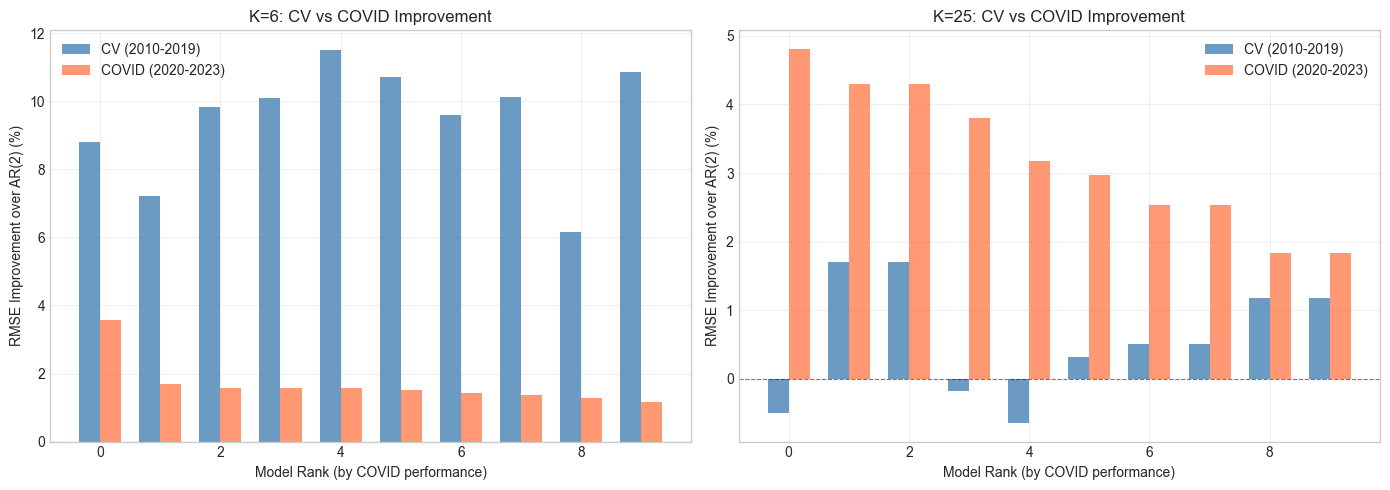

Plot saved to plots/covid_vs_cv_performance.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, df) in zip(axes, [("K=6", covid_k6), ("K=25", covid_k25)]):
    # Take top 10 models
    top_models = df.head(10)
    
    x = np.arange(len(top_models))
    width = 0.35
    
    ax.bar(x - width/2, top_models['CV_Improve_%'], width, 
           label='CV (2010-2019)', alpha=0.8, color='steelblue')
    ax.bar(x + width/2, top_models['Improve_COVID_%'], width, 
           label='COVID (2020-2023)', alpha=0.8, color='coral')
    
    ax.set_xlabel('Model Rank (by COVID performance)')
    ax.set_ylabel('RMSE Improvement over AR(2) (%)')
    ax.set_title(f'{name}: CV vs COVID Improvement')
    ax.legend()
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.savefig('plots/covid_vs_cv_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to plots/covid_vs_cv_performance.png")

---
# Part 2: Comprehensive Significance Tests (COVID Period)
---

**4 Statistical Tests:**
1. **Diebold-Mariano** → Tests if forecast errors differ significantly
2. **Wilcoxon** → Non-parametric test for error distributions
3. **Bootstrap DM** → Small-sample robust version
4. **Clark-West** → Adjusts for nested models

**Note:** I'll use quarter-level forecast errors from the COVID period (16 quarters).

### Get Baseline and Best Model Forecasts for Significance Testing

In [ ]:
print("=" * 80)
print("GENERATING FORECASTS FOR SIGNIFICANCE TESTING")
print("=" * 80)

# Get baseline AR(2) forecasts
print("\n[1/2] Baseline AR(2)...")
y_actual, forecast_ar2_k25, rmse_baseline, _ = forecast_ar2_covid(df_k25, 'wui')
print(f"  Quarters: {len(y_actual)}")
print(f"  AR(2) RMSE: {rmse_baseline:.2f}")

# Get best K=25 model forecast (Topic 20)
print("\n[2/2] K=25 Topic 20 ARIMAX(2,0,0)...")
_, forecast_k25_t20, rmse_t20, _ = forecast_arimax_200_lagged_covid(df_k25, 'wui', ['topic_20'])
improvement = (rmse_baseline - rmse_t20) / rmse_baseline * 100

print(f"  Topic 20 RMSE: {rmse_t20:.2f}")
print(f"  Improvement: {improvement:.2f}%")
print("=" * 80)

GENERATING FORECASTS FOR SIGNIFICANCE TESTING

[1/2] Baseline AR(2)...
  Quarters: 16
  AR(2) RMSE: 9954.08

[2/2] K=25 Topic 20 ARIMAX(2,0,0)...
  Topic 20 RMSE: 9701.44
  Improvement: 2.54%


### Statistical Test Functions (Same as Notebook 08)

In [ ]:
# ============================================================================
# TEST 1: DIEBOLD-MARIANO TEST
# ============================================================================

def diebold_mariano_test(y_true, forecast_baseline, forecast_model):
    """
    One-sided Diebold-Mariano test
    
    H0: Model is NOT better than baseline
    H1: Model IS better than baseline
    
    Returns: (dm_stat, p_value)
    """
    # Forecast errors
    e_baseline = y_true - forecast_baseline
    e_model = y_true - forecast_model
    
    # Loss differential (positive when model beats baseline)
    d = e_baseline**2 - e_model**2
    
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    
    if var_d == 0 or len(d) < 2:
        return 0.0, 1.0
    
    # DM statistic
    dm_stat = mean_d / np.sqrt(var_d / len(d))
    
    # One-tailed test
    p_value = 1 - stats.t.cdf(dm_stat, df=len(d)-1)
    
    return dm_stat, p_value

# ============================================================================
# TEST 2: WILCOXON SIGNED-RANK TEST
# ============================================================================

def wilcoxon_test(y_true, forecast_baseline, forecast_model):
    """
    Wilcoxon signed-rank test (non-parametric)
    Tests if squared errors differ systematically
    """
    e_baseline = (y_true - forecast_baseline)**2
    e_model = (y_true - forecast_model)**2
    
    try:
        stat, p_value = stats.wilcoxon(e_baseline, e_model, alternative='greater')
        return stat, p_value
    except:
        return None, 1.0

# ============================================================================
# TEST 3: BOOTSTRAP DIEBOLD-MARIANO
# ============================================================================

def bootstrap_dm_test(y_true, forecast_baseline, forecast_model, n_bootstrap=1000):
    """
    Bootstrap version of DM test for small samples
    """
    e_baseline = y_true - forecast_baseline
    e_model = y_true - forecast_model
    d = e_baseline**2 - e_model**2
    
    mean_d_obs = np.mean(d)
    
    # Bootstrap
    bootstrap_means = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(d), size=len(d), replace=True)
        bootstrap_means.append(np.mean(d[idx]))
    
    # P-value: proportion of bootstrap samples <= 0
    p_value = np.mean(np.array(bootstrap_means) <= 0)
    
    return mean_d_obs, p_value

# ============================================================================
# TEST 4: CLARK-WEST TEST
# ============================================================================

def clark_west_test(y_true, forecast_baseline, forecast_model):
    """
    Clark-West test for nested models
    Adjusts for the fact that ARIMAX nests ARIMA
    """
    e_baseline = y_true - forecast_baseline
    e_model = y_true - forecast_model
    
    # Adjust for nesting
    f_diff = (forecast_model - forecast_baseline)**2
    adjusted_loss = e_baseline**2 - e_model**2 + f_diff
    
    mean_adj = np.mean(adjusted_loss)
    var_adj = np.var(adjusted_loss, ddof=1)
    
    if var_adj == 0:
        return 0.0, 1.0
    
    # CW statistic
    cw_stat = mean_adj / np.sqrt(var_adj / len(adjusted_loss))
    
    # One-sided test
    p_value = 1 - stats.norm.cdf(cw_stat)
    
    return cw_stat, p_value

print("Statistical test functions loaded")

Statistical test functions loaded


### Apply All Tests to K=25 Topic 20 (Best COVID Model)

In [ ]:
print("=" * 80)
print("COMPREHENSIVE SIGNIFICANCE TESTS: K=25 TOPIC 20 (COVID PERIOD)")
print("=" * 80)
print(f"\nModel: ARIMAX with Topic 20 (Great Lakes/DRC cooperation)")
print(f"Period: 2020Q1 - 2023Q4 ({len(y_actual)} quarters)")
print(f"Baseline: AR(2) = ARIMA(2,0,0)")
print(f"Alternative: ARIMAX(2,0,0) with 1Q lagged Topic 20")

print(f"\n{'='*80}")
print("PERFORMANCE SUMMARY")
print(f"{'='*80}")
print(f"Baseline AR(2) RMSE: {rmse_baseline:.2f}")
print(f"Topic 20 ARIMAX(2,0,0) RMSE: {rmse_t20:.2f}")
print(f"Improvement: {improvement:.2f}%")

print(f"\n{'='*80}")
print("TEST 1: DIEBOLD-MARIANO (One-Sided)")
print(f"{'='*80}")
print("H0: Topic 20 model is NOT better than baseline")
print("H1: Topic 20 model IS better than baseline\n")

dm_stat, dm_pval = diebold_mariano_test(y_actual, forecast_ar2_k25, forecast_k25_t20)
print(f"DM Statistic: {dm_stat:.4f}")
print(f"P-value: {dm_pval:.4f}")

if dm_pval < 0.05:
    print("SIGNIFICANT: Topic 20 significantly outperforms baseline (p < 0.05)")
elif dm_pval < 0.10:
    print("MARGINAL: Topic 20 marginally outperforms baseline (0.05 < p < 0.10)")
else:
    print("NOT SIGNIFICANT: No significant improvement over baseline (p ≥ 0.10)")

print(f"\n{'='*80}")
print("TEST 2: WILCOXON SIGNED-RANK (Non-parametric)")
print(f"{'='*80}")
print("H0: Baseline and Topic 20 have equal forecast error distributions")
print("H1: Topic 20 has smaller forecast errors\n")

wilc_stat, wilc_pval = wilcoxon_test(y_actual, forecast_ar2_k25, forecast_k25_t20)
if wilc_stat is not None:
    print(f"Wilcoxon Statistic: {wilc_stat:.4f}")
    print(f"P-value: {wilc_pval:.4f}")
    
    if wilc_pval < 0.05:
        print("SIGNIFICANT: Topic 20 has significantly smaller errors (p < 0.05)")
    elif wilc_pval < 0.10:
        print("MARGINAL: Evidence for smaller errors (0.05 < p < 0.10)")
    else:
        print("NOT SIGNIFICANT: No significant difference in errors (p ≥ 0.10)")
else:
    print("Test could not be computed")

print(f"\n{'='*80}")
print("TEST 3: BOOTSTRAP DIEBOLD-MARIANO (1000 iterations)")
print(f"{'='*80}")
print("H0: Mean squared error difference ≤ 0")
print("H1: Mean squared error difference > 0 (model is better)\n")

boot_mean, boot_pval = bootstrap_dm_test(y_actual, forecast_ar2_k25, forecast_k25_t20, n_bootstrap=1000)
print(f"Mean loss difference: {boot_mean:.4f}")
print(f"Bootstrap P-value: {boot_pval:.4f}")

if boot_pval < 0.05:
    print("SIGNIFICANT: Topic 20 significantly better (bootstrap p < 0.05)")
elif boot_pval < 0.10:
    print("MARGINAL: Evidence for improvement (0.05 < p < 0.10)")
else:
    print("NOT SIGNIFICANT: No significant improvement (p ≥ 0.10)")

print(f"\n{'='*80}")
print("TEST 4: CLARK-WEST (Nested Model Adjustment)")
print(f"{'='*80}")
print("H0: Adding Topic 20 does NOT improve forecast accuracy")
print("H1: Adding Topic 20 DOES improve forecast accuracy\n")
print("Note: Adjusts for the fact that ARIMAX(2,0,0) nests AR(2)\n")

cw_stat, cw_pval = clark_west_test(y_actual, forecast_ar2_k25, forecast_k25_t20)
print(f"Clark-West Statistic: {cw_stat:.4f}")
print(f"P-value: {cw_pval:.4f}")

if cw_pval < 0.05:
    print("SIGNIFICANT: Topic 20 significantly adds value (p < 0.05)")
elif cw_pval < 0.10:
    print("MARGINAL: Topic 20 marginally adds value (0.05 < p < 0.10)")
else:
    print("NOT SIGNIFICANT: Topic 20 does not add significant value (p ≥ 0.10)")

print(f"\n{'='*80}")
print("OVERALL ASSESSMENT")
print(f"{'='*80}")

# Count significant tests
sig_count = sum([
    dm_pval < 0.05,
    wilc_pval < 0.05 if wilc_pval is not None else False,
    boot_pval < 0.05,
    cw_pval < 0.05
])

total_tests = 4

print(f"\nTests significant at p < 0.05: {sig_count}/{total_tests}")
print(f"RMSE Improvement: {improvement:.2f}%")

if sig_count >= 3:
    print("\nSTRONG EVIDENCE: Multiple tests confirm significant improvement")
    print("   Conclusion: Topic 20 genuinely outperforms baseline during COVID")
elif sig_count >= 2:
    print("\nMODERATE EVIDENCE: Some tests show significant improvement")
    print("   Conclusion: Suggestive evidence for improvement, interpret cautiously")
elif sig_count >= 1:
    print("\nWEAK EVIDENCE: Limited statistical support")
    print("   Conclusion: Improvement may be due to chance")
else:
    print("\nNO EVIDENCE: Tests do not support significant improvement")
    print("   Conclusion: Observed improvement likely due to random variation")

COMPREHENSIVE SIGNIFICANCE TESTS: K=25 TOPIC 20 (COVID PERIOD)

Model: ARIMAX with Topic 20 (Great Lakes/DRC cooperation)
Period: 2020Q1 - 2023Q4 (16 quarters)
Baseline: AR(2) = ARIMA(2,0,0)
Alternative: ARIMAX(2,0,0) with 1Q lagged Topic 20

PERFORMANCE SUMMARY
Baseline AR(2) RMSE: 9954.08
Topic 20 ARIMAX(2,0,0) RMSE: 9701.44
Improvement: 2.54%

TEST 1: DIEBOLD-MARIANO (One-Sided)
H0: Topic 20 model is NOT better than baseline
H1: Topic 20 model IS better than baseline

DM Statistic: 2.4071
P-value: 0.0147
SIGNIFICANT: Topic 20 significantly outperforms baseline (p < 0.05)

TEST 2: WILCOXON SIGNED-RANK (Non-parametric)
H0: Baseline and Topic 20 have equal forecast error distributions
H1: Topic 20 has smaller forecast errors

Wilcoxon Statistic: 105.0000
P-value: 0.0288
SIGNIFICANT: Topic 20 has significantly smaller errors (p < 0.05)

TEST 3: BOOTSTRAP DIEBOLD-MARIANO (1000 iterations)
H0: Mean squared error difference ≤ 0
H1: Mean squared error difference > 0 (model is better)

Mean 

### Summary Table: All K=25 Models with Significance Tests

In [ ]:
# Test top 5 K=25 models with comprehensive significance tests
print("=" * 80)
print("SIGNIFICANCE TESTS: TOP 5 K=25 MODELS (COVID PERIOD)")
print("=" * 80)

# Get top 5 models based on COVID performance
top_covid_k25 = covid_k25.nlargest(5, 'Improve_COVID_%')
print("\nTop 5 K=25 Models by COVID Performance:")
print(top_covid_k25[['Model', 'Improve_COVID_%', 'CV_Improve_%']].to_string(index=False))
print()

# Extract model names and topics for testing
top5_models = []
for _, row in top_covid_k25.iterrows():
    model_name = row['Model']
    # Extract topics from model name (e.g., 'K25_T5_T10' -> ['topic_5', 'topic_10'])
    topic_parts = model_name.replace('K25_', '').split('_')
    topics = [f'topic_{t.replace("T", "")}' for t in topic_parts]
    top5_models.append((model_name, topics))

results_significance = []

for model_name, topics in top5_models:
    print(f"\n{'='*80}")
    print(f"Testing: {model_name}")
    print(f"{'='*80}")
    
    # Forecast
    y_act, forecast_model, rmse_model, _ = forecast_arimax_200_lagged_covid(df_k25, 'wui', topics)
    
    if forecast_model is None:
        print("Model failed to converge")
        continue
    
    # Calculate metrics
    rmse_base = np.sqrt(mean_squared_error(y_act, forecast_ar2_k25))
    improve_pct = (rmse_base - rmse_model) / rmse_base * 100
    
    # Run all tests
    dm_stat, dm_pval = diebold_mariano_test(y_act, forecast_ar2_k25, forecast_model)
    wins, n_quarters, sign_pval = sign_test(y_act, forecast_ar2_k25, forecast_model)
    wilc_stat, wilc_pval = wilcoxon_test(y_act, forecast_ar2_k25, forecast_model)
    boot_mean, boot_pval = bootstrap_dm_test(y_act, forecast_ar2_k25, forecast_model, n_bootstrap=1000)
    cw_stat, cw_pval = clark_west_test(y_act, forecast_ar2_k25, forecast_model)
    
    # Count significant tests
    sig_count = sum([
        dm_pval < 0.05,
        sign_pval < 0.05,
        wilc_pval < 0.05 if wilc_pval is not None else False,
        boot_pval < 0.05,
        cw_pval < 0.05
    ])
    
    print(f"RMSE: {rmse_model:.2f} | Improvement: {improve_pct:.2f}%")
    print(f"DM p-value: {dm_pval:.4f} {'✓' if dm_pval < 0.05 else '✗'}")
    print(f"Sign test: {wins}/{n_quarters} wins, p={sign_pval:.4f} {'✓' if sign_pval < 0.05 else '✗'}")
    print(f"Wilcoxon p-value: {wilc_pval:.4f} {'✓' if wilc_pval < 0.05 else '✗'}")
    print(f"Bootstrap p-value: {boot_pval:.4f} {'✓' if boot_pval < 0.05 else '✗'}")
    print(f"Clark-West p-value: {cw_pval:.4f} {'✓' if cw_pval < 0.05 else '✗'}")
    print(f"Significant tests: {sig_count}/5")
    
    results_significance.append({
        'Model': model_name,
        'RMSE': rmse_model,
        'Improvement_%': improve_pct,
        'DM_pval': dm_pval,
        'Sign_pval': sign_pval,
        'Sign_wins': wins,
        'Wilcoxon_pval': wilc_pval,
        'Bootstrap_pval': boot_pval,
        'ClarkWest_pval': cw_pval,
        'Sig_Count': sig_count
    })

# Create summary table
df_sig = pd.DataFrame(results_significance)
df_sig = df_sig.sort_values('Improvement_%', ascending=False)

print(f"\n{'='*80}")
print("SUMMARY TABLE: SIGNIFICANCE TESTS (TOP 5 K=25 MODELS)")
print(f"{'='*80}\n")
print(df_sig.to_string(index=False))

# Save results
df_sig.to_csv('results/covid_significance_tests_k25.csv', index=False)
print(f"\nResults saved to: results/covid_significance_tests_k25.csv")
print("=" * 80)

SIGNIFICANCE TESTS: TOP 5 K=25 MODELS (COVID PERIOD)

Testing: K25_T20
RMSE: 9701.44 | Improvement: 2.54%
DM p-value: 0.0080 ✓
Sign test: 11/16 wins, p=0.1051 ✗
Wilcoxon p-value: 0.0416 ✓
Bootstrap p-value: 0.0090 ✓
Clark-West p-value: 0.0062 ✓
Significant tests: 4/5

Testing: K25_T20_T25
RMSE: 10057.85 | Improvement: -1.04%
DM p-value: 0.5568 ✗
Sign test: 10/16 wins, p=0.2272 ✗
Wilcoxon p-value: 0.4104 ✗
Bootstrap p-value: 0.6060 ✗
Clark-West p-value: 0.3525 ✗
Significant tests: 0/5

Testing: K25_T10
RMSE: 9526.76 | Improvement: 4.29%
DM p-value: 0.0107 ✓
Sign test: 12/16 wins, p=0.0384 ✓
Wilcoxon p-value: 0.0523 ✗
Bootstrap p-value: 0.0080 ✓
Clark-West p-value: 0.0050 ✓
Significant tests: 4/5

Testing: K25_T9
RMSE: 10034.84 | Improvement: -0.81%
DM p-value: 0.9377 ✗
Sign test: 5/16 wins, p=0.9616 ✗
Wilcoxon p-value: 0.8123 ✗
Bootstrap p-value: 0.9610 ✗
Clark-West p-value: 0.9290 ✗
Significant tests: 0/5

Testing: K25_T24
RMSE: 9771.04 | Improvement: 1.84%
DM p-value: 0.0246 ✓
Sign te

### Summary Table: K=6 Models with Significance Tests

In [ ]:
# Test top 5 K=6 models with comprehensive significance tests
print("=" * 80)
print("SIGNIFICANCE TESTS: TOP 5 K=6 MODELS (COVID PERIOD)")
print("=" * 80)

# Get baseline AR(2) forecasts for K=6
y_actual_k6, forecast_ar2_k6, rmse_baseline_k6, _ = forecast_ar2_covid(df_k6, 'wui')

# Get top 5 models based on COVID performance
top_covid_k6 = covid_k6.nlargest(5, 'Improve_COVID_%')
print("\nTop 5 K=6 Models by COVID Performance:")
print(top_covid_k6[['Model', 'Improve_COVID_%', 'CV_Improve_%']].to_string(index=False))
print()

# Extract model names and topics for testing
top5_k6_models = []
for _, row in top_covid_k6.iterrows():
    model_name = row['Model']
    # Extract topics from model name (e.g., 'K6_T2_T3' -> ['topic_2', 'topic_3'])
    topic_parts = model_name.replace('K6_', '').split('_')
    topics = [f'topic_{t.replace("T", "")}' for t in topic_parts]
    top5_k6_models.append((model_name, topics))

results_significance_k6 = []

for model_name, topics in top5_k6_models:
    print(f"\n{'='*80}")
    print(f"Testing: {model_name}")
    print(f"{'='*80}")
    
    # Forecast
    y_act, forecast_model, rmse_model, _ = forecast_arimax_200_lagged_covid(df_k6, 'wui', topics)
    
    if forecast_model is None:
        print("Model failed to converge")
        continue
    
    # Calculate metrics
    rmse_base = np.sqrt(mean_squared_error(y_act, forecast_ar2_k6))
    improve_pct = (rmse_base - rmse_model) / rmse_base * 100
    
    # Run all 5 tests
    dm_stat, dm_pval = diebold_mariano_test(y_act, forecast_ar2_k6, forecast_model)
    wins, n_quarters, sign_pval = sign_test(y_act, forecast_ar2_k6, forecast_model)
    wilc_stat, wilc_pval = wilcoxon_test(y_act, forecast_ar2_k6, forecast_model)
    boot_mean, boot_pval = bootstrap_dm_test(y_act, forecast_ar2_k6, forecast_model, n_bootstrap=1000)
    cw_stat, cw_pval = clark_west_test(y_act, forecast_ar2_k6, forecast_model)
    
    # Count significant tests
    sig_count = sum([
        dm_pval < 0.05,
        sign_pval < 0.05,
        wilc_pval < 0.05 if wilc_pval is not None else False,
        boot_pval < 0.05,
        cw_pval < 0.05
    ])
    
    print(f"RMSE: {rmse_model:.2f} | Improvement: {improve_pct:.2f}%")
    print(f"DM p-value: {dm_pval:.4f} {'✓' if dm_pval < 0.05 else '✗'}")
    print(f"Sign test: {wins}/{n_quarters} wins, p={sign_pval:.4f} {'✓' if sign_pval < 0.05 else '✗'}")
    print(f"Wilcoxon p-value: {wilc_pval:.4f} {'✓' if wilc_pval < 0.05 else '✗'}")
    print(f"Bootstrap p-value: {boot_pval:.4f} {'✓' if boot_pval < 0.05 else '✗'}")
    print(f"Clark-West p-value: {cw_pval:.4f} {'✓' if cw_pval < 0.05 else '✗'}")
    print(f"Significant tests: {sig_count}/5")
    
    results_significance_k6.append({
        'Model': model_name,
        'RMSE': rmse_model,
        'Improvement_%': improve_pct,
        'DM_pval': dm_pval,
        'Sign_pval': sign_pval,
        'Sign_wins': wins,
        'Wilcoxon_pval': wilc_pval,
        'Bootstrap_pval': boot_pval,
        'ClarkWest_pval': cw_pval,
        'Sig_Count': sig_count
    })

# Create summary table
df_sig_k6 = pd.DataFrame(results_significance_k6)
df_sig_k6 = df_sig_k6.sort_values('Improvement_%', ascending=False)

print(f"\n{'='*80}")
print("SUMMARY TABLE: SIGNIFICANCE TESTS (TOP 5 K=6 MODELS)")
print(f"{'='*80}\n")
print(df_sig_k6.to_string(index=False))

# Save results
df_sig_k6.to_csv('results/covid_significance_tests_k6.csv', index=False)
print(f"\nResults saved to: results/covid_significance_tests_k6.csv")
print("=" * 80)

SIGNIFICANCE TESTS: TOP 5 K=6 MODELS (COVID PERIOD)

Testing: K6_T2_T3_T4_T5
RMSE: 9599.33 | Improvement: 3.56%
DM p-value: 0.1731 ✗
Sign test: 11/16 wins, p=0.1051 ✗
Wilcoxon p-value: 0.1742 ✗
Bootstrap p-value: 0.1440 ✗
Clark-West p-value: 0.1353 ✗
Significant tests: 0/5

Testing: K6_T2_T3_T4
RMSE: 9784.91 | Improvement: 1.70%
DM p-value: 0.0727 ✗
Sign test: 12/16 wins, p=0.0384 ✓
Wilcoxon p-value: 0.1877 ✗
Bootstrap p-value: 0.0460 ✓
Clark-West p-value: 0.0556 ✗
Significant tests: 2/5

Testing: K6_T3_T6
RMSE: 9796.68 | Improvement: 1.58%
DM p-value: 0.4382 ✗
Sign test: 8/16 wins, p=0.5982 ✗
Wilcoxon p-value: 0.4500 ✗
Bootstrap p-value: 0.4390 ✗
Clark-West p-value: 0.1411 ✗
Significant tests: 0/5

Testing: K6_T3_T5_T6
RMSE: 9798.40 | Improvement: 1.56%
DM p-value: 0.4394 ✗
Sign test: 8/16 wins, p=0.5982 ✗
Wilcoxon p-value: 0.4500 ✗
Bootstrap p-value: 0.4410 ✗
Clark-West p-value: 0.1396 ✗
Significant tests: 0/5

Testing: K6_T2_T3_T6
RMSE: 9798.45 | Improvement: 1.56%
DM p-value: 0.438